<a href="https://colab.research.google.com/github/Riverag0011/ADS-504-02-Machine-Learning-Deep-Learning-For-Data-Science/blob/main/Assignment_3_1_Exercises_Code_GR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 3.1 Exercises**

Name: Gabi Rivera\
Date: 14Jul2024\
Course: ADS504-02

## Clothing Data

For this assignment, you will work with data from a popular clothing website, modcloth.com. This
gives us a chance to work with feature engineering, feature extraction, and unbalanced,
multiclass datasets. You will train several different classification models based on different types
of data from this dataset.

As you go through the assignment, you will create several tables and figures. After you
complete the programming section, use the tables and figures you generated to answer the questions.


In [ ]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import json
# This ensures that sklearn 0.24 is loaded on Google colab
#!pip uninstall scikit-learn -y
#!pip install -U scikit-learn
#!pip install --upgrade threadpoolctl

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import Perceptron
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import warnings

## Pre-Processing and Loading Data:

In your Blackboard assignment prompt is the modcloth_final_data.json file, which is a series of
JSON objects from a popular clothing store, modcloth.com. Load these objects into a list, and
then use pd.DataFrame to convert that list into a dataframe called modcloth_data.


In [ ]:
df = pd.read_json('/content/modcloth_final_data.json', lines = True)
df.head()

modcloth = pd.DataFrame(df)
# remove rows with null quality values
modcloth = modcloth[modcloth['quality'].notna()]
# remove bust outlier
modcloth = modcloth[modcloth['bust'] != '37-39']

modcloth.head()

,item_id,waist,size,quality,cup size,hips,bra size,category,bust,height,user_name,length,fit,user_id,shoe size,shoe width,review_summary,review_text
0,123373,29.0,7,5.0,d,38.0,34.0,new,36,5ft 6in,Emily,just right,small,991571,NaN,NaN,NaN,NaN
1,123373,31.0,13,3.0,b,30.0,36.0,new,NaN,5ft 2in,sydneybraden2001,just right,small,587883,NaN,NaN,NaN,NaN
2,123373,30.0,7,2.0,b,NaN,32.0,new,NaN,5ft 7in,Ugggh,slightly long,small,395665,9.0,NaN,NaN,NaN
3,123373,NaN,21,5.0,dd/e,NaN,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,NaN,NaN
4,123373,NaN,18,5.0,b,NaN,36.0,new,NaN,5ft 2in,dberrones1,slightly long,small,944840,NaN,NaN,NaN,NaN


In [ ]:
modcloth.describe()

,item_id,waist,size,quality,hips,bra size,user_id,shoe size
count,82721.000000,2842.000000,82721.000000,82721.000000,56030.000000,76722.000000,82721.000000,27885.00000
mean,469317.955912,31.323716,12.661585,3.949046,40.358058,35.972237,498817.452908,8.14506
std,213997.525023,5.291110,8.271349,0.992782,5.827110,3.224544,286379.634536,1.32422
min,123373.000000,20.000000,0.000000,1.000000,30.000000,28.000000,6.000000,5.00000
25%,314980.000000,28.000000,8.000000,3.000000,36.000000,34.000000,252860.000000,7.00000
50%,454030.000000,30.000000,12.000000,4.000000,39.000000,36.000000,497769.000000,8.00000
75%,658440.000000,34.000000,15.000000,5.000000,43.000000,38.000000,744746.000000,9.00000
max,807722.000000,50.000000,38.000000,5.000000,60.000000,48.000000,999972.000000,11.50000


In [ ]:
modcloth.isna().sum()

item_id               0
waist             79879
size                  0
quality               0
cup size           6231
hips              26691
bra size           5999
category              0
bust              70889
height             1103
user_name             0
length               25
fit                   0
user_id               0
shoe size         54836
shoe width        64134
review_summary     6722
review_text        6722
dtype: int64

Create a variable named ‘labels’ using the ‘quality’ column. These are the labels that we will use
for the rest of this assignment.

Next, you will transform these data into numerical vectors you can use for classification.
For the variables ‘waist’, ’size’, ’hips’, ‘bra size’, and ‘shoe size’ you can use
pd.to_numeric(modcloth_data[variable] to convert them to numerical values. Store
these in a data frame.


For the next variable, ‘height’, the strings need some processing to convert them into numeric
values. You can use pd.apply to apply a transformation to the column of the data frame. Write a
short python function to convert these to a meaningful categorical variable: convert the strings to
height (in inches). Also, do this for the variable ‘bust’ - there are some outliers that could be handled by writing and applying another python function. Convert height and bust and store the
numeric values to the same data frame as the other numeric features.


In [ ]:
# Define the Functions for Height and Bust Conversion

def conv_height(x):
    if pd.isnull(x):
        return x
    spt = x.split(' ')
    ft = int(spt[0].split('ft')[0])
    inch = 0
    if len(spt) > 1:
        inch = int(spt[1].split('in')[0])
    return (ft * 12) + inch
def conv_bust(x):
    if pd.isnull(x):
        return x
    spt = x.split('-')
    # if range, split the difference
    if len(spt) > 1:
        return (int(spt[1]) - int(spt[0]) // 2) + int(spt[0])
    return int(spt[0])

In [ ]:
# Extract 'quality' Column
labels = modcloth['quality']

# Convert waist, size, hips, bra size, shoe size to numeric:
num_cols = ['waist', 'size', 'hips', 'bra size', 'shoe size', 'quality']

# store to dataframe
num_df = pd.DataFrame()
num_df[num_cols] = modcloth[num_cols].apply(pd.to_numeric, errors='coerce')

# Convert height
num_df['height (inch)'] = modcloth['height'].apply(conv_height)

# Convert bust
num_df['bust (inch)'] = modcloth['bust'].apply(conv_bust)

# See Numerical DF Table
num_df.head()

,waist,size,hips,bra size,shoe size,quality,height (inch),bust (inch)
0,29.0,7,38.0,34.0,NaN,5.0,66.0,36.0
1,31.0,13,30.0,36.0,NaN,3.0,62.0,NaN
2,30.0,7,NaN,32.0,9.0,2.0,67.0,NaN
3,NaN,21,NaN,NaN,NaN,5.0,NaN,NaN
4,NaN,18,NaN,36.0,NaN,5.0,62.0,NaN


Plot the height using seaborn’s distplot function. You should see a normal distribution of height,
which should match your expectations for what the distribution of human heights should look
like.


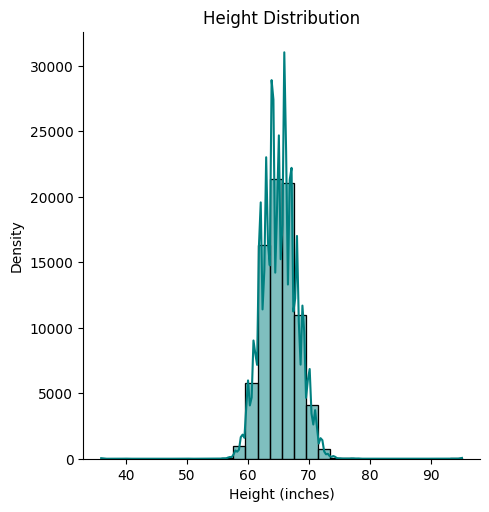

In [ ]:
# Plot Height's Distribution
sns.displot(num_df['height (inch)'], kde=True, bins=30, color='Teal')
plt.title('Height Distribution')
plt.xlabel('Height (inches)')
plt.ylabel('Density')
plt.show()

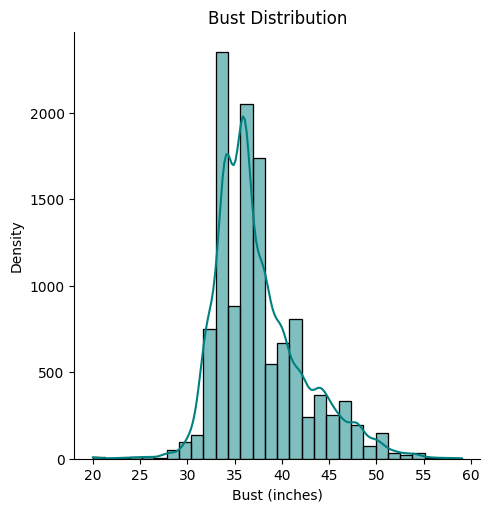

In [ ]:
# Plot Bust's Distribution
sns.displot(num_df['bust (inch)'], kde=True, bins=30, color='Teal')
plt.title('Bust Distribution')
plt.xlabel('Bust (inches)')
plt.ylabel('Density')
plt.show()

Make a plot of the waist data, which should look like this:


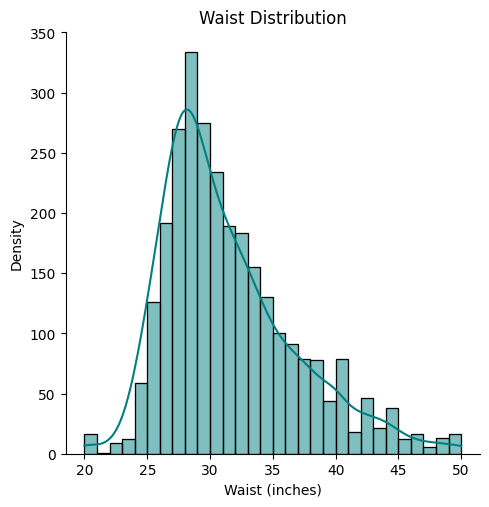

In [ ]:
# Plot Waist's Distribution
sns.displot(num_df['waist'], kde=True, bins=30, color='Teal')
plt.title('Waist Distribution')
plt.xlabel('Waist (inches)')
plt.ylabel('Density')
plt.show()

## Categorical Data for Reviews

For these values, ‘cup size’, ‘length’, ‘category’, use OneHotEncoder to convert these to a data
frame called cat_feat.
Use make_pipeline to compare these two classifiers:



```
balanced_model = make_pipeline(,Perceptronclass_weight='balanced'))
unbalanced_model = make_pipeline(,Perceptron())
```




Train a classifier using the data in cat_feat. Use train_test_split and test_size=0.50 to get a
50/50 train and test split.
Use metrics.plot_confusion_matrix and metrics.classification_report to report and visualize the
confusion matrix and results. Perform this for both the balanced and unbalanced models.

In [ ]:
# Extract the features and target variable
X = modcloth[['cup size', 'length', 'category']]
y = modcloth['quality']

# One-hot encode the categorical features
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' to avoid multicollinearity
X_encoded = encoder.fit_transform(X)

# Create a DataFrame from the encoded features
cat_feat = pd.DataFrame(X_encoded,
                        columns=encoder.get_feature_names_out(['cup size',
                                                               'length',
                                                               'category']))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(cat_feat, y, test_size=0.50,
                                                    random_state=42)

# Define the balanced and unbalanced Perceptron models
balanced_model = make_pipeline(Perceptron(class_weight='balanced',
                                          random_state=42))
unbalanced_model = make_pipeline(Perceptron(random_state=42))

# Train the balanced model
balanced_model.fit(X_train, y_train)

# Train the unbalanced model
unbalanced_model.fit(X_train, y_train)

Pipeline(steps=[('perceptron', Perceptron(random_state=42))])

Balanced Model:
Confusion Matrix:


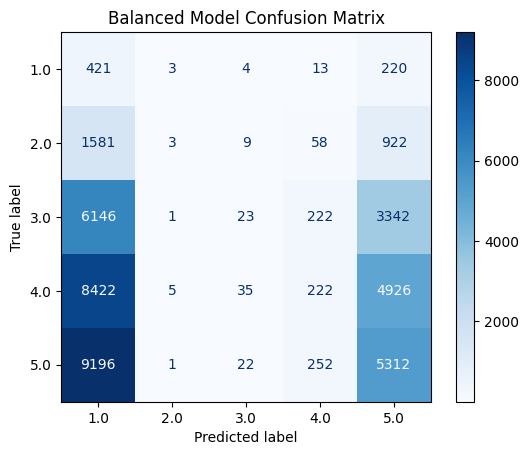

In [ ]:
# Predict with the balanced model
y_pred_balanced = balanced_model.predict(X_test)

# Predict with the unbalanced model
y_pred_unbalanced = unbalanced_model.predict(X_test)

# Evaluate the balanced model
print("Balanced Model:")
print("Confusion Matrix:")
conf_matrix_balanced = metrics.confusion_matrix(y_test, y_pred_balanced,
                                                labels=balanced_model.classes_)
disp_balanced = ConfusionMatrixDisplay(conf_matrix_balanced,
                                       display_labels=balanced_model.classes_)
disp_balanced.plot(cmap=plt.cm.Blues)
plt.title('Balanced Model Confusion Matrix')
plt.show()

In [ ]:
#print classification_report balanced here
print("Balanced Classification Report:")
print(metrics.classification_report(y_test, y_pred_balanced))

Balanced Classification Report:
              precision    recall  f1-score   support

         1.0       0.02      0.64      0.03       661
         2.0       0.23      0.00      0.00      2573
         3.0       0.25      0.00      0.00      9734
         4.0       0.29      0.02      0.03     13610
         5.0       0.36      0.36      0.36     14783

    accuracy                           0.14     41361
   macro avg       0.23      0.20      0.09     41361
weighted avg       0.30      0.14      0.14     41361



Unbalanced Model:
Confusion Matrix:


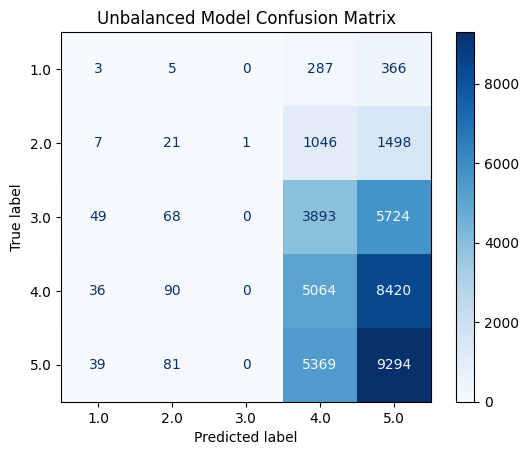

In [ ]:
#Plot unBalanced here
print("Unbalanced Model:")
print("Confusion Matrix:")
conf_matrix_unbalanced = metrics.confusion_matrix(y_test, y_pred_unbalanced,
                                                  labels=unbalanced_model.classes_)
disp_unbalanced = ConfusionMatrixDisplay(conf_matrix_unbalanced,
                                         display_labels=unbalanced_model.classes_)
disp_unbalanced.plot(cmap=plt.cm.Blues)
plt.title('Unbalanced Model Confusion Matrix')
plt.show()

In [ ]:
#print classification_report Unbalanced here
print("Unbalanced Classification Report:")
print(metrics.classification_report(y_test, y_pred_unbalanced))

Unbalanced Classification Report:
              precision    recall  f1-score   support

         1.0       0.02      0.00      0.01       661
         2.0       0.08      0.01      0.01      2573
         3.0       0.00      0.00      0.00      9734
         4.0       0.32      0.37      0.35     13610
         5.0       0.37      0.63      0.46     14783

    accuracy                           0.35     41361
   macro avg       0.16      0.20      0.17     41361
weighted avg       0.24      0.35      0.28     41361



## Categorical and Numeric Features
Next, you will add in data from the numeric features. Unfortunately, many of these values are
missing: not every JSON object will have a value for this numeric value.


In [ ]:
# Combine categorical and numerical variables
comb_df = pd.merge(cat_feat, num_df[num_df.index.isin(cat_feat.index)],
                   left_index=True, right_index=True)
comb_df.head()

,cup size_aa,cup size_b,cup size_c,cup size_d,cup size_dd/e,cup size_ddd/f,cup size_dddd/g,cup size_h,cup size_i,cup size_j,...,category_tops,category_wedding,waist,size,hips,bra size,shoe size,quality,height (inch),bust (inch)
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,29.0,7,38.0,34.0,NaN,5.0,66.0,36.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,31.0,13,30.0,36.0,NaN,3.0,62.0,NaN
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,30.0,7,NaN,32.0,9.0,2.0,67.0,NaN
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,21,NaN,NaN,NaN,5.0,NaN,NaN
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,18,NaN,36.0,NaN,5.0,62.0,NaN


In [ ]:
# Missing values of combined df
comb_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82652 entries, 0 to 82720
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   cup size_aa            82652 non-null  float64
 1   cup size_b             82652 non-null  float64
 2   cup size_c             82652 non-null  float64
 3   cup size_d             82652 non-null  float64
 4   cup size_dd/e          82652 non-null  float64
 5   cup size_ddd/f         82652 non-null  float64
 6   cup size_dddd/g        82652 non-null  float64
 7   cup size_h             82652 non-null  float64
 8   cup size_i             82652 non-null  float64
 9   cup size_j             82652 non-null  float64
 10  cup size_k             82652 non-null  float64
 11  cup size_nan           82652 non-null  float64
 12  length_slightly long   82652 non-null  float64
 13  length_slightly short  82652 non-null  float64
 14  length_very long       82652 non-null  float64
 15  length_

## Pipelines


You will use imputation
as implemented in https://scikit-learn.org/stable/modules/impute.html to fill in the missing values
before classification: **use SimpleImputer.**


Next, you will create three pipelines. Create one pipeline using SimpleImputer to impute the missing
values and the balanced perceptron.


Next, create a pipeline using **preprocessing.Normalizer()**.

Finally, create a different pipeline using preprocessing.**StandardScaler()**.

For each of the pipeline,l do fivefold cross-validation, using
**scores = cross_val_score(model, X, y, cv=5,scoring=’accuracy’)**

to compute the accuracy of each of the pipelines.
Create a table, with a row (labeled) for each pipeline you created.


In [ ]:
# Prepare the data
X = comb_df.drop(columns=['quality'])
y = comb_df['quality']

# Simple Imputer pipeline
impute_pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan,
                                                  strategy='median'))])
impute_model = make_pipeline(impute_pipe, Perceptron(class_weight='balanced'))

# Normalize pipeline
normalize_pipe = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('normalizer', Normalizer())
])
normalize_model = make_pipeline(normalize_pipe,
                                Perceptron(class_weight='balanced'))

# Standardize pipeline
standardize_pipe = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler())
])
standardize_model = make_pipeline(standardize_pipe,
                                  Perceptron(class_weight='balanced'))

In [ ]:
# Perform 5-fold cross-validation for each pipeline
pipelines = {
    'SimpleImputer': impute_model,
    'Normalizer': normalize_model,
    'StandardScaler': standardize_model
}

results = {}

for name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    results[name] = {
        'max': scores.max(),
        'min': scores.min(),
        'mean': scores.mean()
    }

## Model Accuracy


The table should report the
*maximum*, *minimum*, and *mean* of accuracy for each of the pipelines.

In [ ]:
# Create a table of results
from tabulate import tabulate

table = [
    [name, f"{res['max']:.4f}", f"{res['min']:.4f}", f"{res['mean']:.4f}"]
    for name, res in results.items()
]

print(tabulate(table, headers=['Pipeline', 'Max Accuracy', 'Min Accuracy',
                               'Mean Accuracy'], tablefmt='grid'))

+----------------+----------------+----------------+-----------------+
| Pipeline       |   Max Accuracy |   Min Accuracy |   Mean Accuracy |
+================+================+================+=================+
| SimpleImputer  |         0.357  |         0.0621 |          0.2373 |
+----------------+----------------+----------------+-----------------+
| Normalizer     |         0.3575 |         0.0674 |          0.266  |
+----------------+----------------+----------------+-----------------+
| StandardScaler |         0.2944 |         0.1983 |          0.2331 |
+----------------+----------------+----------------+-----------------+


## Text Data from Reviews

Finally, you will use the words in the consumer reviews to build a classifier to predict the results.
*corpus = modcloth_data['review_text']*

Create a new variable from the text data, after removing outliers, which are records that contain
no text data (these will be nans in your data frame). This new variable is a list of strings, where
every string is a consumer review.



In [ ]:
# Extract the 'review_text' column
corpus = modcloth['review_text']

# Remove outliers: Drop records with no text data (NaNs)
corpus = corpus.dropna()
corpus.describe()

count        75999
unique       73247
top       Love it!
freq           153
Name: review_text, dtype: object

**TfidfVectorizer**

Pass this new variable to sklearn’sTfidfVectorizer
(https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) to load
the data. Create a new dataframe called X from the bag of words features, using
*pd.DataFrame.sparse.from_spmatrix*, and subset the labels to only those which have text data
present.



**Feature Selection - Top 10**

Next, use feature selection
(https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection) to subset the
text data to only the most relevant features. Be sure to do this based on the training set, then
apply the transformation to the test set. Using the pipeline can make this step easier.

Use *SelectKBest* and *chi-2* to select features. Make sure you have the latest version (at least
0.24 of scikit-learn, or you may get errors).

Print a list of the top ten features selected. Hint: Use
*vectorizer.get_feature_names(), XKBest.fit()* and then *XNew.get_support()*.




In [ ]:
# Drop NaNs from the label column to match the text data
labels = modcloth['quality'].dropna()
labels = modcloth.loc[corpus.index, 'quality']

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
spmat = vectorizer.fit_transform(corpus)

# Get feature names from the TfidfVectorizer
feat_names = vectorizer.get_feature_names_out()

# Create a new DataFrame from the sparse matrix
X = pd.DataFrame.sparse.from_spmatrix(spmat, columns=feat_names)

# Subset the labels to only those which have text data present
labels = labels[corpus.index]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.5,
                                                    random_state=42)
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

Training data shape: (37999, 21790)
Test data shape: (38000, 21790)
Training labels shape: (37999,)
Test labels shape: (38000,)


In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning)

# Create the pipeline with SelectKBest and KNN classifier
pipeline = Pipeline([
        ('kbest', SelectKBest(chi2, k=10)),
        ('knn', KNeighborsClassifier())
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.2f}")


# Get the top 10 features
kbest = pipeline.named_steps['kbest']
top_features_indices = kbest.get_support(indices=True)
top_features = [feat_names[i] for i in top_features_indices]

# Print the top 10 features
print(f"Top 10 features: {top_features}")

Test set accuracy: 0.35
Top 10 features: ['apart', 'cheap', 'disappointed', 'love', 'perfect', 'poor', 'poorly', 'returned', 'ripped', 'terrible']


**Accuracy**

For k in the range [10,25,50,100,250,500,1000,10000], plot the accuracy of the
classifier for each value of k.

In [ ]:
k_vals = [10,25,50,100,250,500,1000,10000]
results = []

for k in k_vals:
  # Create the pipeline with SelectKBest and KNN classifier
    pipeline = Pipeline([
        ('kbest', SelectKBest(chi2, k=k)),
        ('knn', KNeighborsClassifier())
    ])

    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    train_acc = cv_scores.mean()

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)
    test_acc = pipeline.score(X_test, y_test)

    # Append results
    results.append({'k-value': k, 'Training Accuracy': train_acc, 'Test Accuracy': test_acc})

In [ ]:
# Create a DataFrame from the results
results_df = pd.DataFrame(results)
results_df

,k-value,Training Accuracy,Test Accuracy
0,10,0.330088,0.348553
1,25,0.322930,0.352895
2,50,0.356668,0.358974
3,100,0.367536,0.381789
4,250,0.366247,0.376605
5,500,0.363457,0.367711
6,1000,0.361720,0.361711
7,10000,0.321140,0.315921


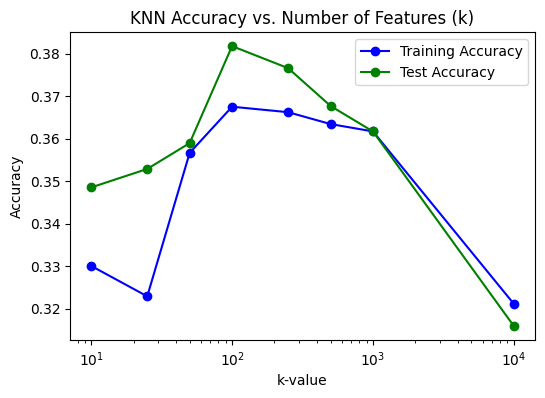

In [ ]:
# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(results_df['k-value'], results_df['Training Accuracy'], marker='o',
         label='Training Accuracy', color='blue')
plt.plot(results_df['k-value'], results_df['Test Accuracy'], marker='o',
         label='Test Accuracy', color='green')
plt.xscale('log')
plt.xlabel('k-value')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy vs. Number of Features (k)')
plt.legend()
plt.show()